[[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 0.]]
[[  0. 146.  20. ...  50. 179. 162.]
 [146.   0.  74. ...  48. 199.  43.]
 [ 20.  74.   0. ... 115. 124. 184.]
 ...
 [ 50.  48. 115. ...   0.  20. 141.]
 [179. 199. 124. ...  20.   0.  10.]
 [162.  43. 184. ... 141.  10.   0.]]

Temps total d'exécution: 0.0029637813568115234 secondes
{0: [0, 24, 30, 27, 18, 38, 16, 32, 45, 0], 1: [0, 46, 34, 23, 37, 31, 49, 48, 17, 0], 2: [0, 4, 7, 42, 47, 44, 19, 35, 25, 0], 3: [0, 15, 5, 39, 29, 26, 14, 43, 9, 0], 4: [0, 6, 3, 2, 11, 12, 28, 41, 13, 0], 5: [0, 40, 1, 20, 36, 10, 8, 21, 33, 0], 6: [0, 22, 0]}
La valeur du chemin initial est : 15299.0

---------------------------------------------

Sa valeur est de : 2490.0 mn, soit 41.50 h

Temps d'execution : 5.905992031097412 secondes




Text(0.5, 1.0, '\nExploration de la zone de recherche par notre algorithme\n')

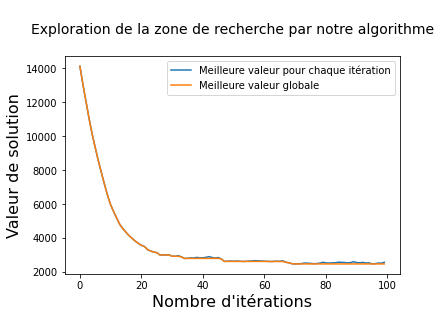

In [4]:
import numpy as np
import time
import matplotlib.pyplot as plt
import timeit
import random
from copy import deepcopy


random.seed(6)
nb_villes = 500 #Nombre de villes à générer
minVehicule = 50
maxVehicule = 100
tempsMax=200 #Temps (Distance) max séparant 2 villes

def generer_matrice_adjacence(taille,typeDeGraphe):
    matrice = np.empty((taille, taille))              
    if(typeDeGraphe == 'Complete'):               
        for i in range(taille):
            for j in range(i,taille):
                valeur = 1 if i!=j else 0 
                matrice[i][j] = valeur
                matrice[j][i] = valeur
    else:
         for i in range(taille):
            for j in range(i,taille):
                valeur = random.randint(0, 1)  if i!=j else 0
                matrice[i][j] = valeur
                matrice[i][j] = valeur
    return matrice
    

matriceAdjacence = generer_matrice_adjacence(nb_villes, "Complete")
print(matriceAdjacence)

def generer_matrice_pondere(matrice):
    for i in range(len(matrice)):
        for j in range(i,len(matrice)):
            if(matrice[i][j] != 0):
                valeur = random.randint(0, tempsMax)
                matrice[i][j] = valeur
                matrice[j][i] = valeur
    return matrice



start = time.time() #Commence le calcul du temps d'exécution
graphe = generer_matrice_pondere(matriceAdjacence) ##Génère une matrice pour n villes et avec un temps maximum
print(graphe)
stop = time.time() #Stop le calcul du temps d'exécution

print("\nTemps total d'exécution: " + str(stop-start) + " secondes")



#Renvoi le temps total d'un chemin
def weightSol(sol,graphe):
    return sum(graphe[sol[i][j]][sol[i][j+1]] for i in sol for j in range(len(sol[i])-1))

#Donne le chemin à suivre du voyageur de commerce sous forme de tableau d'indice
def generate_solution(matrice,minVehicule,maxVehicule):
    sol = {}
    matriceSearch = [i for i in range(len(matrice))]
    matriceSearch.remove(0)
    i = 0
    nbvehicule = random.randint(minVehicule,maxVehicule)
    while (len(matriceSearch) > 0):
        way = []
        way.append(0)
        for j in range(0,(len(matrice)//nbvehicule)) :
            if len(matriceSearch) > 0 :
                value = random.choice(matriceSearch)
                way.append(value)
                matriceSearch.remove(value)
            else: 
                break
        way.append(0)
        sol[i] = way
        i += 1
    return sol

sol=generate_solution(graphe,minVehicule,maxVehicule)
print(sol)

#Génère les voisins valides d'une solution
def reformSolution(solutionConcatenate:list):
    idx_list = [idx + 1 for idx in range(len(solutionConcatenate)-1) if solutionConcatenate[idx] == 0 and solutionConcatenate[idx+1]==0]
    solutionTransform = [solutionConcatenate[i: j] for i, j in zip([0] + idx_list, idx_list +  ([len(solutionConcatenate)] if idx_list[-1] != len(solutionConcatenate) else []))]
    solution = {truck:way for truck,way in enumerate(solutionTransform)}
    return solution
def voisinage(sol:dict):
    voisinage = []
    solution = []
    for truckWay in sol.values():
        solution += truckWay
    for i in range (1,len(solution)-1):
        for n in range(1,len(solution)-i-2):
            neighborPath=solution.copy()
            if solution[i] == 0:
               continue
            elif solution[i+n] == 0:
                index = n + 2
                neighborPath = solution[:i]+[solution[i],solution[i+index]]+solution[i+1:]
                neighborPath.pop(i+index+1)
                voisinage.append(reformSolution(neighborPath))
                neighborPath = solution[:i+index]+[solution[i+index],solution[i]]+solution[i+index+1:]
                neighborPath.pop(i)
                voisinage.append(reformSolution(neighborPath))
            else:
                neighborPath[i], neighborPath[i+n] = neighborPath[i+n], neighborPath[i]
                voisinage.append(reformSolution(neighborPath))
    return voisinage

def tabuSearch(sol, tabuLength, iterMax, graphe):

    nbIter = 0
    tabuList = list()

    initialElement = sol
    # variables solutions pour la recherche du voisin optimal non tabou
    currentElement = initialElement
    bestNeighbor=currentElement
    bestNeighborGlobal=currentElement

    # variables valeurs pour la recherche du voisin optimal non tabou
    bestCost=100000
    bestCostGlobal=100000

    # variables pour l'affichage
    nbTabou=0
    bestGlobalFound=0
    
    # liste des solutions courantes et des meilleures trouvées, pour afficher la trajectoire
    paths=list()
    bestPaths=list()
    
    while (nbIter<iterMax):
        nbIter += 1       
        bestCost=100000

        # on parcours tous les voisins de la solution courante
        for neighbor in voisinage(currentElement):
            if weightSol(neighbor,graphe) < bestCost:
                if neighbor not in tabuList:
                    bestCost = weightSol(neighbor,graphe)
                    bestNeighbor = neighbor
          
        # on met a jour la meilleure solution rencontree depuis le debut
        if bestCost<bestCostGlobal:
            bestGlobalFound+=1
            bestNeighborGlobal=bestNeighbor
            bestCostGlobal=bestCost
            #print("Meilleur global trouvé ! : " + str(bestNeighborGlobal) + " avec une valeur de :" + str(bestCostGlobal))
      
        bestPaths.append(bestCostGlobal)
        
        # on passe au meilleur voisin non tabou trouve     
        currentElement=bestNeighbor.copy()
        paths.append(bestCost)
        
        # on met a jour la liste tabou
        tabuList.append(bestNeighbor)

        # on supprime la solution la plus ancienne si la liste tabou à atteint sa taille maximale
        if len(tabuList) > tabuLength:
            del tabuList[0]

    # On insère à l'élément initiale la ville d'origine
    return bestNeighborGlobal, paths, bestPaths, initialElement


#------------------ Execution de l'algorithme ---------------------

# Paramètres de génération du graphe
nbVilles=0
tempsMax=500

graphe = generer_matrice_pondere(matriceAdjacence)

# Modifier ce paramètre pour modifier le nombre d'itération maximum de la recherche tabou
iterMaximum=100
# Modifier ce paramètre pour modifier la taille maximum de la liste tabou
tabuMax=len(graphe)
# Modifier ce paramètre pour activer ou non l'utilisation du plus proche voisin comme chemin initial
useNearestNeighbor=True
# Modifier ce paramètre pour changer la ville de départ
departureCity=0

startTime = time.time()
sol, paths, bestPaths, initialPath=tabuSearch(sol, tabuLength=tabuMax, iterMax=iterMaximum, graphe=graphe)
execTime = (time.time() - startTime)

print("La valeur du chemin initial est :",str(weightSol(initialPath,graphe)))
print("\n---------------------------------------------")
#print("\nLe meilleur chemin trouvé est : " + str(resNearestNeighbor(sol)))
print("\nSa valeur est de : " + str(weightSol(sol,graphe)) + " mn, soit " + str("{:.2f}".format(weightSol(sol,graphe)/60)) + " h")
print("\nTemps d'execution : " + str(execTime) + " secondes\n\n")

# Affichage des résultats sur le graphique
plt.xlabel("Nombre d'itérations", fontsize=16)
plt.ylabel("Valeur de solution", fontsize=16)

res = plt.plot(range(iterMaximum), paths,label='Meilleure valeur pour chaque itération')
res = plt.plot(range(iterMaximum), bestPaths,label='Meilleure valeur globale')

plt.legend()
font2 = {'size':14}
plt.title("\nExploration de la zone de recherche par notre algorithme\n", loc = 'center',fontdict = font2)
